# Forecasting
In this lesson, we will practice forecasting using the following methods:
- Last observed value
- Simple average
- Moving average
- Holt's Linear Trend
- Previous cycle

In the next lesson we will forecast using Facebook's Prophet algorithm.

We will walk through steps from previous lessons to get the data ready to model

- Acquire data: prepare.acquire_store_data()
- Prepare data: prepare.prep_store_data()
- Split data: prepare.split_store_data()

Then we will forecast and evaluate using each method.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import timedelta, datetime
from time import strftime
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

import acquire, prepare

## Wrangle

In [8]:
# Acquire the data
df = acquire.get_store_data()

# Print the shape and the head
print(store.shape)
df.head(3)

(913000, 16)


,sale_amount,sale_date,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013


1. sale_date to datetime
2. sort values by date
3. set index
4. new field: dollars_sold = sale_amount * item_price
5. rename sale_amount to items_sold to make the two columns easier to understand what the data represents.
6. resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)
7. remove leap days!

In [9]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)

df = df[df.index != '2016-02-29']

In [10]:
print(df.shape)
df.head()

(1825, 2)


,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0
2013-01-03 00:00:00+00:00,78169.48,14488.0
2013-01-04 00:00:00+00:00,84467.73,15677.0
2013-01-05 00:00:00+00:00,87621.85,16237.0


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores.

## Split
1. We will use the training proportion method to split.
2. Identify the total length of the dataframe and multiple by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
4. Return train and test dataframes.

In [11]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

validate_end_index

1459

In [12]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

### Verify Splits

In [13]:
# Does the length of each df equate to the length of the original df?
print(len(train) + len(validate) + len(test) == len(df))

True


In [14]:
# Does the first row of original df equate to the first row of train?
print(df.head(1) == train.head(1))

                           dollars_sold  items_sold
ds                                                 
2013-01-01 00:00:00+00:00          True        True


In [16]:
# Is the last row of train the day before the first row of validate? 
pd.concat([train.tail(1), validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-07-01 00:00:00+00:00,164573.20,30703.0
2015-07-02 00:00:00+00:00,178036.64,33134.0


In [17]:
# And the same for validate to test?
pd.concat([validate.tail(1), test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30 00:00:00+00:00,120033.64,22296.0
2016-12-31 00:00:00+00:00,128009.31,23792.0


In [18]:
# Is the last row of test the same as the last row of our original dataframe?
pd.concat([test.tail(1), df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31 00:00:00+00:00,140905.74,26420.0
2017-12-31 00:00:00+00:00,140905.74,26420.0


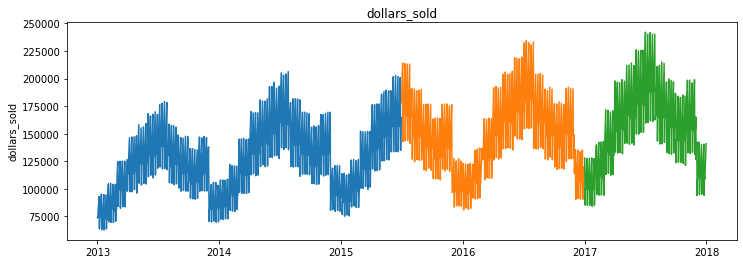

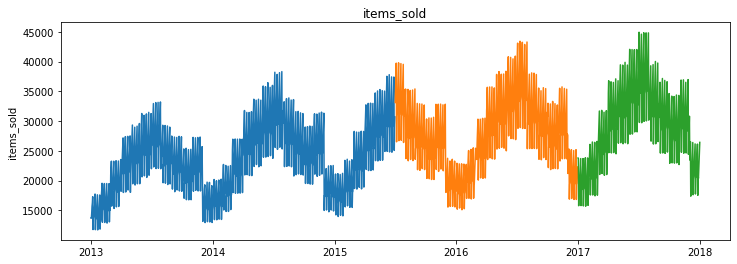

In [19]:
# Let's plot our data first, viewing where the data is split into train and test.

for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's **create a couple of functions that will be helpful in evaluating each of the methods that follow.**

`evaluate()` will compute the **Mean Squared Error** and the **Rood Mean Squared Error** to evaluate.

In [20]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [21]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start.

In [22]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [23]:
eval_df

,model_type,target_var,rmse


## Forecast: Last observed value
The simplest method for forecasting is to predict all future values to be the last observed value.

### Make Predictions

In [30]:
dollars = round(train['dollars_sold'][-1:][0], 2)
dollars

164573.2

In [31]:
items = train['items_sold'][-1:][0]
items

30703.0

In [32]:
yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]}, 
                       index = validate.index)

yhat_df.head(2) # You can see, when peeking into yhat_df, that every predicted value is the same.

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,30703.0,164573.2
2015-07-03 00:00:00+00:00,30703.0,164573.2


In [35]:
yhat_df.describe()

,items_sold,dollars_sold
count,547.0,5.470000e+02
mean,30703.0,1.645732e+05
std,0.0,1.660437e-09
min,30703.0,1.645732e+05
25%,30703.0,1.645732e+05
50%,30703.0,1.645732e+05
75%,30703.0,1.645732e+05
max,30703.0,1.645732e+05


### Plot Actual vs. Predicted Values
Now, let's plot actual and predicted values

dollars_sold -- RMSE: 35402


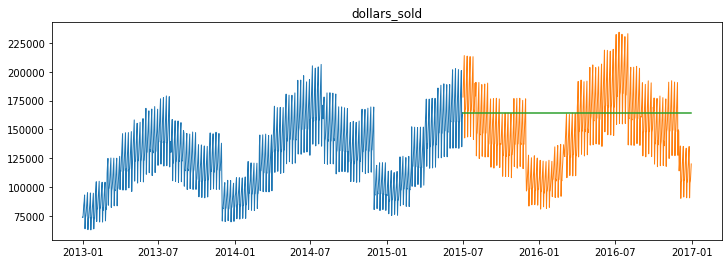

items_sold -- RMSE: 6621


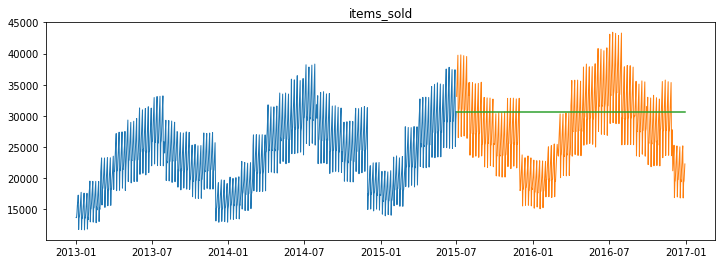

In [33]:
for col in train.columns:
    plot_and_eval(col)

### Evalutate
Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [36]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [37]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0


## Forecast: Simple Average
1. Take the simple average of historical values and use that value to predict future values.
2. This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

### Make Predictions

In [38]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

items, dollars

(23717.94, 127517.85)

In [39]:
def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,23717.94,127517.85
2015-07-03 00:00:00+00:00,23717.94,127517.85


### Plot Actural vs. Predicted Values
Now, let's plot and evaluate the performance of our time series model using Simple Average

dollars_sold -- RMSE: 39664


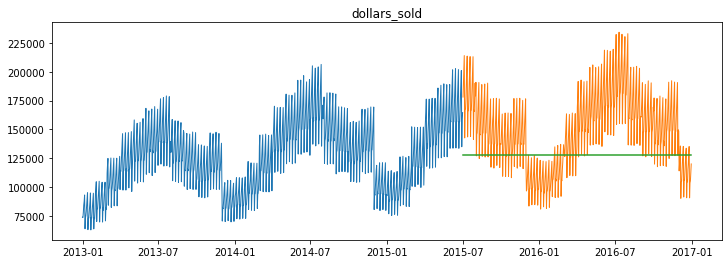

items_sold -- RMSE: 7378


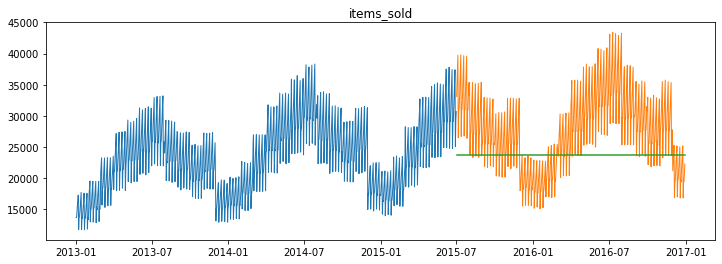

In [40]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate
Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [41]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


## Forecast - Moving Average
In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

In [44]:
train['dollars_sold'].tail(30).mean()

168957.912

In [45]:
train['dollars_sold'].rolling(30).mean().tail()

ds
2015-06-27 00:00:00+00:00    169307.076000
2015-06-28 00:00:00+00:00    170365.098000
2015-06-29 00:00:00+00:00    168925.788333
2015-06-30 00:00:00+00:00    167925.392000
2015-07-01 00:00:00+00:00    168957.912000
Name: dollars_sold, dtype: float64

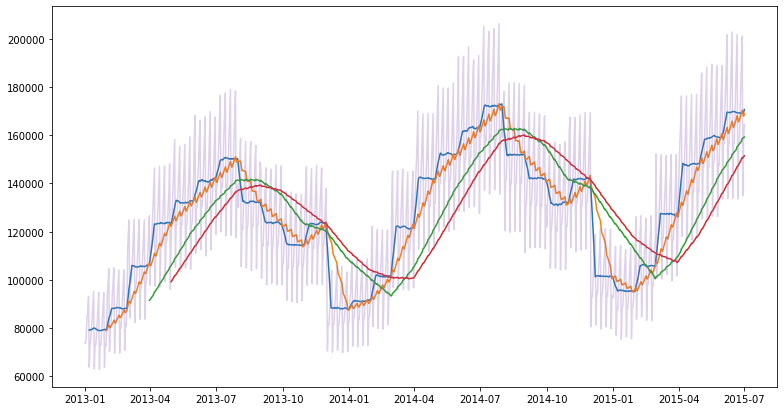

In [48]:
plt.figure(figsize=(13,7))
plt.plot(train['dollars_sold'].rolling(7).mean())
plt.plot(train['dollars_sold'].rolling(30).mean())
plt.plot(train['dollars_sold'].rolling(90).mean())
plt.plot(train['dollars_sold'].rolling(120).mean())
plt.plot(train['dollars_sold'], alpha=.3)

### Make Predictions

In [49]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,31432.77,168957.91
2015-07-03 00:00:00+00:00,31432.77,168957.91
2015-07-04 00:00:00+00:00,31432.77,168957.91


### Plot Actual vs. Predicted Values
Now, let's plot and evaluate the performance of our time series model using Moving Average

dollars_sold -- RMSE: 37378


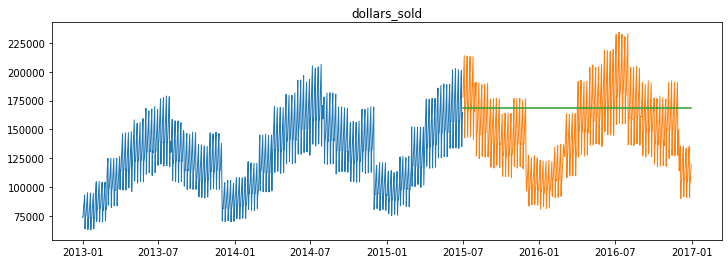

items_sold -- RMSE: 6954


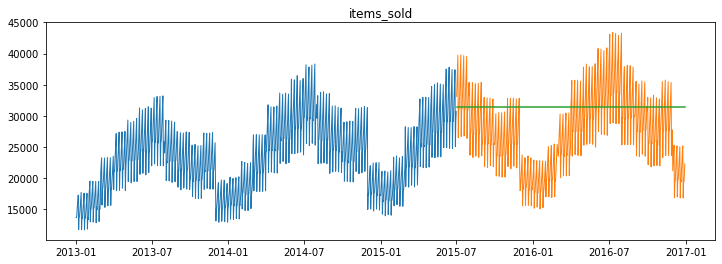

In [50]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate
Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [51]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0


Let's try out several other vales for periods:

In [52]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

eval_df

,model_type,target_var,rmse
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0
6,1d moving average,items_sold,6621.0
7,1d moving average,dollars_sold,35402.0
8,4d moving average,items_sold,6592.0
9,4d moving average,dollars_sold,35515.0


In [56]:
eval_df.sort_values(by='rmse').head(3)

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0
14,52d moving average,items_sold,6563.0
8,4d moving average,items_sold,6592.0


### Which is best so far?

In [57]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]a
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0
17,104d moving average,dollars_sold,32803.0
